# Surface Laplacian Example

In [40]:
# import required libraries
import numpy as np
from scipy import special
import math
import mne
import pylab as plt

In [41]:
# make Mike X Cohen's example data into mne Epochs object
data = np.genfromtxt('example data.csv', delimiter=',') # load the data
data = data.reshape((64, 640, 99), order='F') # re-arrange data into a 3d array
data = np.rollaxis(data, 2) # swap data's shape
data = (data)*1e-6 # re-scale data
coordinates = np.genfromtxt('coordinates.csv', delimiter=',') # get electrode positions

ch_names = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5','FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1',
            'P1','P3','P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2','AF8','AF4','AFz','Fz',
            'F2','F4','F6','F8','FT8','FC6','FC4','FC2','FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2',
            'P4','P6','P8','P10','PO8','PO4','O2'] # channel names

sfreq = 256 # sampling rate

pos = np.rollaxis(coordinates, 1) # swap coordinates' shape
pos[:,[0]], pos[:,[1]] = pos[:,[1]], pos[:,[0]] # swap coordinates' positions
pos[:,[0]] = pos[:,[0]] * -1 # invert first coordinate
dig_ch_pos = dict(zip(ch_names, pos)) # assign channel names to coordinates
montage = mne.channels.DigMontage(dig_ch_pos=dig_ch_pos) # make montage

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg', montage=montage) # create info

epochs = mne.EpochsArray(data=data, info=info, tmin=-1) # make Epochs onject

99 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [42]:
# define functions
def surface_laplacian(epochs, leg_order, m, smoothing, montage):
    """
    This function attempts to compute the surface laplacian transform to an mne Epochs object. The 
    algorithm follows the formulations of Perrin et al. (1989) and it consists for the most part in a 
    nearly-literal translation of Mike X Cohen's 'Analyzing neural time series data' corresponding MATLAB 
    code (2014).
    
    INPUTS are:
        - epochs: mne Epochs object
        - leg_order: maximum order of the Legendre polynomial
        - m: smothness parameter for G and H
        - smoothing: smothness parameter for the diagonal of G
        - montage: montage to reconstruct the transformed Epochs object (same as in raw data import)
        
    OUTPUTS are:
        - before: sham reconstruction of the original Epochs object
        - after: surface laplacian transform of the original Epochs object
        
    References:
        - Perrin, F., Pernier, J., Bertrand, O. & Echallier, J.F. (1989). Spherical splines for scalp 
          potential and current density mapping. Electroencephalography and clinical Neurophysiology, 72, 
          184-187.
        - Cohen, M.X. (2014). Surface Laplacian In Analyzing neural time series data: theory and practice 
          (pp. 275-290). London, England: The MIT Press.
    """
    # import libraries
    import numpy as np
    from scipy import special
    import math
    import mne
    
    # get electrodes positions
    locs = epochs._get_channel_positions()

    x = locs[:,0]
    y = locs[:,1]
    z = locs[:,2]

    # arrange data
    data = epochs.get_data() # data
    data = np.rollaxis(data, 0, 3)
    orig_data_size = np.squeeze(data.shape)

    numelectrodes = len(x)
    
    # normalize cartesian coordenates to sphere unit
    def cart2sph(x, y, z):
        hxy = np.hypot(x, y)
        r = np.hypot(hxy, z)
        el = np.arctan2(z, hxy)
        az = np.arctan2(y, x)
        return az, el, r

    junk1, junk2, spherical_radii = cart2sph(x,y,z)
    maxrad = np.max(spherical_radii)
    x = x/maxrad
    y = y/maxrad
    z = z/maxrad
    
    # compute cousine distance between all pairs of electrodes
    cosdist = np.zeros((numelectrodes, numelectrodes))
    for i in range(numelectrodes):
        for j in range(i+1,numelectrodes):
            cosdist[i,j] = 1 - (((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2)/2)

    cosdist = cosdist + cosdist.T + np.identity(numelectrodes)

    # get legendre polynomials
    legpoly = np.zeros((leg_order, numelectrodes, numelectrodes))
    for ni in range(leg_order):
        for i in range(numelectrodes):
            for j in range(i+1, numelectrodes):
                #temp = special.lpn(8,cosdist[0,1])[0][8]
                legpoly[ni,i,j] = special.lpn(ni+1,cosdist[i,j])[0][ni+1]

    legpoly = legpoly + np.transpose(legpoly,(0,2,1))

    for i in range(leg_order):
        legpoly[i,:,:] = legpoly[i,:,:] + np.identity(numelectrodes)

    # compute G and H matrixes
    twoN1 = np.multiply(2, range(1, leg_order+1))+1
    gdenom = np.power(np.multiply(range(1, leg_order+1), range(2, leg_order+2)), m, dtype=float)
    hdenom = np.power(np.multiply(range(1, leg_order+1), range(2, leg_order+2)), m-1, dtype=float)

    G = np.zeros((numelectrodes, numelectrodes))
    H = np.zeros((numelectrodes, numelectrodes))

    for i in range(numelectrodes):
        for j in range(i, numelectrodes):

            g = 0
            h = 0

            for ni in range(leg_order):
                g = g + (twoN1[ni] * legpoly[ni,i,j]) / gdenom[ni]
                h = h - (twoN1[ni] * legpoly[ni,i,j]) / hdenom[ni]

            G[i,j] = g / (4*math.pi)
            H[i,j] = -h / (4*math.pi)

    G = G + G.T
    H = H + H.T

    G = G - np.identity(numelectrodes) * G[1,1] / 2
    H = H - np.identity(numelectrodes) * H[1,1] / 2

    if np.any(orig_data_size==1):
        data = data[:]
    else:
        data = np.reshape(data, (orig_data_size[0], np.prod(orig_data_size[1:3])))

    # compute C matrix
    Gs = G + np.identity(numelectrodes) * smoothing
    GsinvS = np.sum(np.linalg.inv(Gs), 0)
    dataGs = np.dot(data.T, np.linalg.inv(Gs))
    C = dataGs - np.dot(np.atleast_2d(np.sum(dataGs, 1)/np.sum(GsinvS)).T, np.atleast_2d(GsinvS))

    # apply transform
    original = np.reshape(data, orig_data_size)
    surf_lap = np.reshape(np.transpose(np.dot(C,np.transpose(H))), orig_data_size)

    # re-arrange data into mne's Epochs object
    events = epochs.events
    event_id = epochs.event_id 
    ch_names = epochs.ch_names
    sfreq = epochs.info['sfreq']
    tmin = epochs.tmin
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg', montage=montage)

    original = np.rollaxis(original, 2, 0)
    surf_lap = np.rollaxis(surf_lap, 2, 0)

    before = mne.EpochsArray(data=original, info=info, events=events, event_id=event_id, tmin=tmin, 
                             on_missing='ignore')
    after = mne.EpochsArray(data=surf_lap, info=info, events=events, event_id=event_id, tmin=tmin, 
                            on_missing='ignore')
    
    return after, before

In [43]:
# compute the transform
surf_lap, surf_orig = surface_laplacian(epochs=epochs, m=4, leg_order=50, smoothing=1e-5, montage=montage)

99 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
99 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [44]:
# make ERPs
bf_erp = surf_orig.average()
at_erp = surf_lap.average()

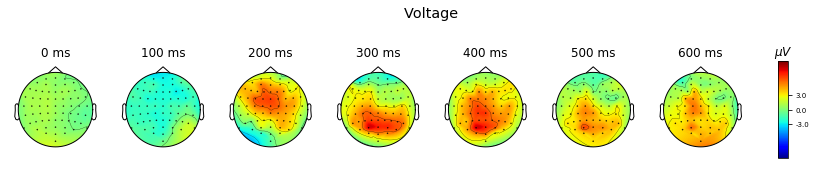

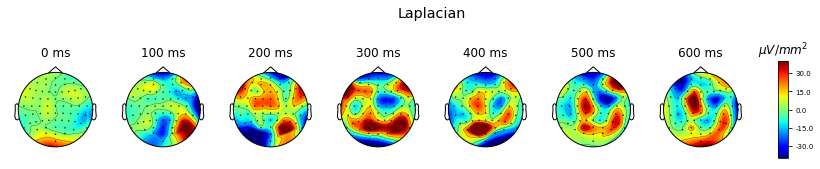

In [46]:
# plot topographies
bf_erp.plot_topomap(np.arange(0, 0.7, 0.1), vmin=-10, vmax=10, units="$\mu V$", time_unit='ms', cmap="jet", title="Voltage", scalings=dict(eeg=1e6))
at_erp.plot_topomap(np.arange(0, 0.7, 0.1), vmin=-40, vmax=40, units="$\mu V/mm^2$", time_unit='ms', cmap="jet", title="Laplacian", scalings=dict(eeg=2e6))
plt.close()